<a href="https://colab.research.google.com/github/YamenHabib/Natural-Language-Inference-NLI-/blob/main/natural_language_inference_(NLI)_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [150]:
try:
    from google.colab import drive
    COLAB = True
    print("using Google CoLab")
except:
    print("not using Google CoLab")
    COLAB = False

using Google CoLab


In [151]:
if COLAB:
    !pip install datasets
    !pip install transformers==3
    !pip install colorama

In [152]:
import sys
import torch
from datasets import load_dataset
import numpy as np
from torch.utils.data import RandomSampler, DataLoader, SequentialSampler, TensorDataset
from tqdm import tqdm
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup
from colorama import Fore
import pandas as pd

In [153]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

cuda:0


In [154]:
raw_train_data = load_dataset('glue', 'mrpc', split='train')
raw_eval_data = load_dataset('glue', 'mrpc', split='validation')

Reusing dataset glue (/root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Reusing dataset glue (/root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


In [155]:
print(len(raw_train_data))
raw_train_data[50]

3668


{'idx': 58,
 'label': 1,
 'sentence1': 'Several of the questions asked by the audience in the fast-paced forum were new to the candidates .',
 'sentence2': 'Several of the audience questions were new to the candidates as well .'}

In [156]:
df = pd.DataFrame.from_records(raw_train_data)

Count of label 0 (not_equivalent) is: 1194 and for label 1 (equivalent) is: 2474 




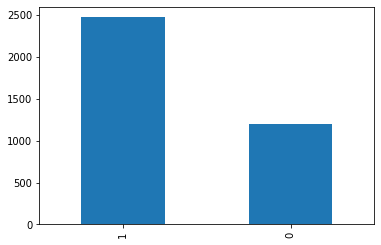

In [162]:
counts = df['label'].value_counts()
print(f"Count of label 0 (not_equivalent) is: {counts[0]} and for label 1 (equivalent) is: {counts[1]}","\n\n")
counts.plot.bar()

In [163]:
# Initialize tokenizer.
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
len(tokenizer)

50265

In [164]:
class glueDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len):
      self.max_len = max_len 
      self.dataset = dataset
    
    def _truncate_pair_of_tokens(self, tokens_a, tokens_b, ):
      while True:
          total_length = len(tokens_a) + len(tokens_b)
          if total_length <= self.max_len - 3:
              break
          if len(tokens_a) > len(tokens_b):
              tokens_a.pop()
          else:
              tokens_b.pop()

    def __getitem__(self, idx):
      example = self.dataset[idx]
      tokens_a = tokenizer.tokenize(example["sentence1"])
      tokens_b = tokenizer.tokenize(example["sentence2"])
      self._truncate_pair_of_tokens(tokens_a, tokens_b)
      tokens = []
      #tokens.append("[CLS]")
      tokens.append(tokenizer.cls_token)
      for token in tokens_a:
          tokens.append(token)
      #tokens.append("[SEP]")
      tokens.append(tokenizer.sep_token) 
      for token in tokens_b:
          tokens.append(token)
      #tokens.append("[SEP]")
      tokens.append(tokenizer.sep_token)
      
      input_ids = tokenizer.convert_tokens_to_ids(tokens)
      input_mask = [1] * len(input_ids)
      while len(input_ids) < self.max_len:
          input_ids.append(0)
          input_mask.append(0)
      
      input_ids   = torch.tensor(input_ids, dtype=torch.int64).to(device)
      input_mask  = torch.tensor(input_mask, dtype=torch.float).to(device)
      label       = torch.tensor(example["label"], dtype=torch.int64).to(device)
      return (input_ids, input_mask, label)

    def __len__(self):
      return len(self.dataset)

In [165]:
batch_size = 16
max_seq_length = 128

In [166]:
train_dataset = glueDataset(raw_train_data, max_seq_length)
train_data_loader = DataLoader(train_dataset, shuffle=False, batch_size=batch_size)

In [167]:
eval_dataset = glueDataset(raw_eval_data, max_seq_length)
eval_data_loader = DataLoader(eval_dataset, shuffle=False, batch_size=batch_size)

In [168]:
class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ROBERTAClassifier, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 128)
        self.bn1 = torch.nn.LayerNorm(128)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(128, 2) 
        torch.nn.init.xavier_uniform_(self.l1.weight)
        torch.nn.init.xavier_uniform_(self.l2.weight)
        
    def forward(self, input_ids, attention_mask):
        #input_ids=None, attention_mask=None, token_type_ids=None
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)
        x = self.l2(x)
        return x

In [169]:
#object to hold out our results and to save and reload model and metrics file
class ResultsSaver():
  def __init__(self, train_len, val_len,output_path):
    self.train_losses = []
    self.val_losses = []
    self.steps = []

    self.best_val_loss = float('Inf')
    
    self.train_len = train_len
    self.val_len = val_len
    
    self.output_path = output_path
  
  def save_checkpoint(self, path, model, valid_loss):
    torch.save({'model_state_dict': model.state_dict(),'valid_loss': valid_loss}, self.output_path + path)

  def load_checkpoint(self, path, model):    
    state_dict = torch.load(self.output_path + path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']

  def save_metrics(self, path):   
    state_dict = {'train_losses': self.train_losses,
                  'val_losses': self.val_losses,
                  'steps': self.steps}
    
    torch.save(state_dict, self.output_path + path)
  
  def load_metrics(self, path):    
    state_dict = torch.load(self.output_path + path, map_location=device)
    return state_dict['train_losses'], state_dict['val_losses'], state_dict['steps']

  def update_train_val_loss(self, model, train_loss, val_loss, step, epoch, num_epochs):

    train_loss = train_loss / self.train_len
    val_loss = val_loss / self.val_len
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.steps.append(step)
    print('Epoch [{}/{}], step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}' .format(epoch+1, num_epochs, step, num_epochs * self.train_len, train_loss, val_loss))
    
    # checkpoint
    if self.best_val_loss > val_loss:
        self.best_val_loss = val_loss
        self.save_checkpoint('/model.pkl', model, self.best_val_loss)
        self.save_metrics('/metric.pkl')

In [170]:
# defin training procedure
def train(model, optimizer, train_data_loader, eval_data_loader, results, scheduler = None, num_epochs = 5 , train_whole_model = False):
    step = 0
    # if we want to train all the model (our added layer + roBERTa)
    if train_whole_model:
      for param in model.roberta.parameters():
        param.requires_grad = True
    # in case we just want to train our added layer.
    else:
      for param in model.roberta.parameters():
        param.requires_grad = False
    
    model.train()
    
    for epoch in range(num_epochs):
        train_loss = 0.0                
        val_loss = 0.0
        for (input_ids, input_mask, y_true) in train_data_loader:
            y_pred = model(input_ids = input_ids, attention_mask = input_mask) 
            loss = torch.nn.CrossEntropyLoss()(y_pred, y_true)
            loss.backward()
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
            optimizer.zero_grad()
            # Update train loss and step
            train_loss += loss.item()
            step += batch_size

        model.eval()
        with torch.no_grad():                    
            for (input_ids, input_mask, y_true) in eval_data_loader:
                y_pred = model(input_ids = input_ids, attention_mask = input_mask)
                loss = torch.nn.CrossEntropyLoss()(y_pred, y_true)
                val_loss += loss.item()
        results.update_train_val_loss(model, train_loss, val_loss, step, epoch, num_epochs)       
        model.train()

    results.save_metrics('/metric.pkl')

In [171]:
output_path = 'here'

In [172]:
steps_per_epoch = len(train_dataset)
model = ROBERTAClassifier(0.4)
model = model.to(device)
# Main training loop
results = ResultsSaver(len(train_dataset), len(eval_dataset), output_path)

In [199]:
NUM_EPOCHS_1 = 8
print(" ............. Training the added Layers only ............. ")
optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = get_linear_schedule_with_warmup(optimizer,  num_warmup_steps=steps_per_epoch*1,  num_training_steps=steps_per_epoch*NUM_EPOCHS_1)

train(model=model, train_data_loader=train_data_loader, eval_data_loader=eval_data_loader, optimizer=optimizer, 
      results = results, scheduler=scheduler, num_epochs=NUM_EPOCHS_1, train_whole_model = False)

print(" ............. Training the whole Model ............. ")
NUM_EPOCHS_2 = 6
optimizer = AdamW(model.parameters(), lr=2e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=steps_per_epoch*2,  num_training_steps=steps_per_epoch*NUM_EPOCHS_2)

train(model=model,  train_data_loader=train_data_loader,  eval_data_loader=eval_data_loader,  optimizer=optimizer, 
      results = results,  scheduler=scheduler,  num_epochs=NUM_EPOCHS_2, train_whole_model=True)

 ............. Training the added Layers only ............. 
Epoch [1/8], step [3680/29344], Train Loss: 0.0446, Valid Loss: 0.0402
Epoch [2/8], step [7360/29344], Train Loss: 0.0452, Valid Loss: 0.0403
Epoch [3/8], step [11040/29344], Train Loss: 0.0443, Valid Loss: 0.0401
Epoch [4/8], step [14720/29344], Train Loss: 0.0438, Valid Loss: 0.0398
Epoch [5/8], step [18400/29344], Train Loss: 0.0426, Valid Loss: 0.0395
Epoch [6/8], step [22080/29344], Train Loss: 0.0431, Valid Loss: 0.0398
Epoch [7/8], step [25760/29344], Train Loss: 0.0420, Valid Loss: 0.0395
Epoch [8/8], step [29440/29344], Train Loss: 0.0412, Valid Loss: 0.0395
 ............. Training the whole Model ............. 
Epoch [1/6], step [3680/22008], Train Loss: 0.0410, Valid Loss: 0.0395
Epoch [2/6], step [7360/22008], Train Loss: 0.0412, Valid Loss: 0.0394
Epoch [3/6], step [11040/22008], Train Loss: 0.0407, Valid Loss: 0.0393
Epoch [4/6], step [14720/22008], Train Loss: 0.0404, Valid Loss: 0.0392
Epoch [5/6], step [18400

In [200]:
def truncate_pair_of_tokens(tokens_a, tokens_b, max_len):
      while True:
          total_length = len(tokens_a) + len(tokens_b)
          if total_length <= max_len - 3:
              break
          if len(tokens_a) > len(tokens_b):
              tokens_a.pop()
          else:
              tokens_b.pop()

In [201]:
def build_features(example, max_len = 128):
  tokens_a = tokenizer.tokenize(example["sentence1"])
  tokens_b = tokenizer.tokenize(example["sentence2"])
  truncate_pair_of_tokens(tokens_a, tokens_b, max_len)
  tokens = []
  #tokens.append("[CLS]")
  tokens.append(tokenizer.cls_token)
  for token in tokens_a:
      tokens.append(token)
  #tokens.append("[SEP]")
  tokens.append(tokenizer.sep_token) 
  for token in tokens_b:
      tokens.append(token)
  #tokens.append("[SEP]")
  tokens.append(tokenizer.sep_token)
  
  input_ids = tokenizer.convert_tokens_to_ids(tokens)
  input_mask = [1] * len(input_ids)
  while len(input_ids) < max_len:
      input_ids.append(0)
      input_mask.append(0)
  
  input_ids   = torch.tensor(input_ids, dtype=torch.int64).to(device)
  input_mask  = torch.tensor(input_mask, dtype=torch.float).to(device)
  return (input_ids, input_mask)

In [202]:
model.eval()

ROBERTAClassifier(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [203]:
example = {
        'sentence1': 'The rain in Spain falls mainly on the plain.',
        'sentence2': 'The rain in Spain falls mainly on the plain.',
    }

input_word_ids_test, input_masks_test = build_features(example)
input_word_ids_test = input_word_ids_test.reshape(1, -1)
input_masks_test = input_masks_test.reshape(1, -1)
result = model(input_ids=input_word_ids_test.to(device),
               attention_mask=input_masks_test.to(device))
result = result[0].detach().cpu()
print(result.numpy())
result = torch.argmax(result).numpy()
print(result)

[-0.59095186  0.29047757]
1


In [204]:
example = {
        'sentence1': 'The rain in Spain falls mainly on the plain.',
        'sentence2': 'Syria is a great country',
    }

input_word_ids_test, input_masks_test = build_features(example)
input_word_ids_test = input_word_ids_test.reshape(1, -1)
input_masks_test = input_masks_test.reshape(1, -1)
result = model(input_ids=input_word_ids_test.to(device), attention_mask=input_masks_test.to(device))
result = result[0].detach().cpu()
print(result.numpy())
result = torch.argmax(result).numpy()
print(result)

[-0.5440463   0.25686145]
1


In [207]:
raw_train_data[500]

{'idx': 559,
 'label': 0,
 'sentence1': 'The conservancy helped in the purchase of the land from the Estate of Samuel Mills Damon for $ 22 million .',
 'sentence2': 'The park service purchased the land from the estate of Samuel Mills Damon for $ 22 million .'}

In [208]:
example = {
    'sentence1': 'The conservancy helped in the purchase of the land from the Estate of Samuel Mills Damon for $ 22 million .',
    'sentence2': 'The park service purchased the land from the estate of Samuel Mills Damon for $ 22 million .'}

input_word_ids_test, input_masks_test = build_features(example)
input_word_ids_test = input_word_ids_test.reshape(1, -1)
input_masks_test = input_masks_test.reshape(1, -1)
result = model(input_ids=input_word_ids_test.to(device), attention_mask=input_masks_test.to(device))
result = result[0].detach().cpu()
print(result.numpy())
result = torch.argmax(result).numpy()
print(result)

[-0.72381943  0.41474888]
1


In [209]:
raw_test_data = load_dataset('glue', 'mrpc', split='test')
len(raw_test_data)

Reusing dataset glue (/root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


1725

In [211]:
raw_test_data[50]

{'idx': 50,
 'label': 1,
 'sentence1': 'The procedure is generally performed in the second or third trimester .',
 'sentence2': 'The technique is used during the second and , occasionally , third trimester of pregnancy .'}

In [210]:
test_dataset = glueDataset(raw_test_data, max_seq_length)
test_data_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [212]:
model.eval()
test_loss = 0
with torch.no_grad():                    
    for (input_ids, input_mask, y_true) in test_data_loader:
        y_pred = model(input_ids = input_ids, attention_mask = input_mask)
        loss = torch.nn.CrossEntropyLoss()(y_pred, y_true)
        test_loss += loss.item()
test_loss /= len(raw_test_data)

In [213]:
test_loss

0.03873657544453939